In [12]:
%config IPCompleter.use_jedi = False

In [13]:
from loader import load_data
import numpy as np
from sklearn.linear_model import RidgeCV
from rascal.representations import SphericalInvariants as SOAP
from rascal.utils import get_optimal_radial_basis_hypers
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_id

In [14]:
train_structures, test_structures, train_properties, test_properties = load_data("../make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz",\
                                                                                    "../make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",selected_species=1,random_subsample_train=200,random_subsample_test=200)

In [15]:
train_structures[0].arrays["center_atoms_mask"].nonzero()

(array([ 4,  5,  6,  7, 24, 25, 26, 27, 32, 33, 34, 35, 44, 45, 46, 47]),)

In [16]:
train_structures[0].get_atomic_numbers()

array([8, 8, 8, 8, 1, 1, 1, 1, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8,
       8, 8, 1, 1, 1, 1, 8, 8, 8, 8, 1, 1, 1, 1, 6, 6, 6, 6, 8, 8, 8, 8,
       1, 1, 1, 1, 8, 8, 8, 8])

In [17]:

def generate_atom_features(frames):
    
    atom_features = []
    count = 0
    
    for frame in train_structures:
        for masked in frame.arrays["center_atoms_mask"].nonzero()[0]:
            new_masked = frame.copy()
            new_masked.arrays.pop("center_atoms_mask")
            #print(type(masked))
            mask_center_atoms_by_id(new_masked, id_select=[masked])
            atom_features.append([new_masked,count])
            count += 1
            
    return np.array(atom_features)
        

In [18]:
generate_atom_features(train_structures)[:,1].dtype

dtype('O')

In [19]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression, Ridge
from sklearn import logging
from copy import deepcopy

In [20]:
import inspect

In [48]:
class SOAPEstimator(BaseEstimator):
    """"""
    def __init__(self, structures, calculator_params, calculator=SOAP, X=(None,None), est_class=Ridge, **kwargs):

        self.est_class = est_class
        self.calculator = calculator
        self.structures = structures
        self.X = X
        self.calculator_params = calculator_params

        # kwargs depend on the model
        for key, value in kwargs.items():
            setattr(self, key, value)
            
        #calculator params depend on calculator used
        for key,value in calculator_params.items():
            setattr(self, key, value)

        # these attributes support the logging functionality
        self.param_names = ['est_class','calculator','structures','X','calculator_params'] + list(kwargs.keys()) #+ list(calculator_params.keys())
        
        #print("")
        #print(self.X[0])
        

    # in the transformer case, we did not implement get_params
    # nor set_params since we inherited them from BaseEstimator
    # but such implementation will not work here due to the **kwargs
    # in the constructor, so we implemented it
    
    def fit(self,X_indices,y,**kwargs):

        #print("I fit")
        print(self.X[1])
        
        if self.X[0] is None:
            print("calculation")
            calculator = self.calculator(**self.calculator_params)
            self.X = tuple([calculator.transform(self.structures).get_features(calculator), deepcopy(self.calculator_params)])  #deepcopy
        
        else:
            #print("data already in store")
            if self.X[1] == self.calculator_params:
                #print(self.X[1])
                #print("equal hyperparameters")
                print("")
            else:
                print("calculation")
                calculator = self.calculator(**self.calculator_params)
                self.X = tuple([calculator.transform(self.structures).get_features(calculator), deepcopy(self.calculator_params)]) #deepcopy

        
        
        est_kwargs = self.get_params() #deepcopy
        #print(kwargs["alpha"])
        
        for key in ['est_class','calculator','structures','X','calculator_params']:
            del est_kwargs[key]
        
        for key in self.calculator_params:
             est_kwargs.pop(key, None)
        
        self.model_ = self.est_class(**est_kwargs)
       
        X = self.X[0][X_indices]
        
        
        # this is not ideal because sample weights can not be passed, and not a general
        #sample_weights = est_kwargs.pop(key, None)
        
        self.model_.fit(X, y)
        # fit must return self
        return self
    
    def _get_features(self):
        return self.X[1]
    
    def _get_paramdicts(self):
        return self.X[1], self.calculator_params
    
    def score(self, X_indices, y, **kwargs):
        X = self.X[0][X_indices]
        score = self.model_.score(X, y, **kwargs)
        #print(score)
        return score
    
    def get_params(self, deep=True):
        # Note: we are ignoring the deep parameter
        # this will not work with estimators that have sub-estimators
        # see https://scikit-learn.org/stable/developers/develop.html#get-params-and-set-params
        
        """additional = {"calculator":self.calculator, "est_class":self.est_class,
                        "structures":self.structures, "X":self.X,"calculator_params":self.calculator_params}"""
        #**additional,
        return {**{param: getattr(self, param)
                for param in self.param_names}}

    def set_params(self, **parameters):
        
        #print("I fit")
        #"print(self.X[0])"
        
        
        for parameter, value in parameters.items():
            #print("parameter: {}, value: {}".format(parameter,value))"
            if parameter in self.calculator_params:
                self.calculator_params[parameter] = value
                print("I update my self.calculator_params")
            setattr(self, parameter, value)
            self.param_names.append(parameter)
            print(self.calculator_params["max_angular"])
        return self   
    
    """def __getattr__(self, key):
        if key != 'model_':
            if hasattr(self, 'model_'):
                return getattr(self.model_, key)
            else:
                return getattr(self.est_class_, key)
        else:
            raise AttributeError(
                "'{}' object has no attribute 'model_'".format(type(self).__name__))"""

In [34]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

     |████████████████████████████████| 100 kB 3.2 MB/s ta 0:00:011
     |████████████████████████████████| 701 kB 20.4 MB/s eta 0:00:01
You should consider upgrading via the '/ssd/scratch/kellner/miniconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [54]:
atom_groups = atom_groups_by_frame(train_structures)

param_grid = {
    'alpha' : [1,2,3],
    'max_angular': [2,3,4,5]#np.logspace(5,-5,20)

}

splits = list(GroupKFold(n_splits=3).split(np.arange(len(train_properties)),train_properties,groups=atom_groups))
clf = GridSearchCV(SOAPEstimator(train_structures,hypers).fit(np.arange(len(train_properties)),train_properties),param_grid,cv=splits)
clf.fit(np.arange(len(train_properties)),train_properties,structures=train_structures,calculator_params=hypers)

None
calculation
3
I update my self.calculator_params
2
{'soap_type': 'PowerSpectrum', 'interaction_cutoff': 3.0, 'max_radial': 3, 'max_angular': 3, 'gaussian_sigma_constant': 0.3, 'gaussian_sigma_type': 'Constant', 'radial_basis': 'GTO', 'normalize': True, 'cutoff_smooth_width': 0.3, 'optimization': {'Spline': {'accuracy': 1e-05}}, 'compute_gradients': False}
calculation
3
I update my self.calculator_params
2
{'soap_type': 'PowerSpectrum', 'interaction_cutoff': 3.0, 'max_radial': 3, 'max_angular': 3, 'gaussian_sigma_constant': 0.3, 'gaussian_sigma_type': 'Constant', 'radial_basis': 'GTO', 'normalize': True, 'cutoff_smooth_width': 0.3, 'optimization': {'Spline': {'accuracy': 1e-05}}, 'compute_gradients': False}
calculation
3
I update my self.calculator_params
2
{'soap_type': 'PowerSpectrum', 'interaction_cutoff': 3.0, 'max_radial': 3, 'max_angular': 3, 'gaussian_sigma_constant': 0.3, 'gaussian_sigma_type': 'Constant', 'radial_basis': 'GTO', 'normalize': True, 'cutoff_smooth_width': 0.3

GridSearchCV(cv=[(array([   0,    1,    2, ..., 7628, 7629, 7630]),
                  array([  16,   17,   18, ..., 7392, 7393, 7394])),
                 (array([  16,   17,   18, ..., 7600, 7601, 7602]),
                  array([   0,    1,    2, ..., 7628, 7629, 7630])),
                 (array([   0,    1,    2, ..., 7628, 7629, 7630]),
                  array([  52,   53,   54, ..., 7600, 7601, 7602]))],
             error_score=nan,
             estimator=SOAPEstimator(X=(array([[5.41661356e-01, 5.17701241e-05, 4.08924940e-05, ...,
        0.00000000e+0...
                                                 Atoms(symbols='C40H32O10', pbc=True, cell=[[9.094064136, 0.0, 0.0], [-1.93013326629, 10.2936803243, 0.0], [-2.17404516048, -2.54633795808, 7.83678248701]], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
                                                 Atoms(symbols='C24H48O16S8', pbc=True, cell=[[12.640681414, 0.0, 0.0], [0.0, 4.16782227242, 0.0], [-2.83162640287, 0.0, 19.7379

In [36]:
myestim = SOAPEstimator(train_structures,hypers)

calculation


In [42]:
myestim.fit(np.arange(len(train_properties)),train_properties)

SOAPEstimator(X=(array([[5.41661356e-01, 5.17701241e-05, 4.08924940e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.41705779e-01, 5.17631114e-05, 4.08899639e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.41661793e-01, 5.17705052e-05, 4.08925444e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.89895039e-01, 9.83149951e-04, 1.5...
                          Atoms(symbols='C40H32O10', pbc=True, cell=[[9.094064136, 0.0, 0.0], [-1.93013326629, 10.2936803243, 0.0], [-2.17404516048, -2.54633795808, 7.83678248701]], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
                          Atoms(symbols='C24H48O16S8', pbc=True, cell=[[12.640681414, 0.0, 0.0], [0.0, 4.16782227242, 0.0], [-2.83162640287, 0.0, 19.7379436821]], center_atoms_mask=..., cs_iso=..., cs_tensor=...), ...])

In [43]:
myestim.X

(array([[5.41661356e-01, 5.17701241e-05, 4.08924940e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.41705779e-01, 5.17631114e-05, 4.08899639e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.41661793e-01, 5.17705052e-05, 4.08925444e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [5.89895039e-01, 9.83149951e-04, 1.53102311e-03, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.19741145e-01, 2.47285689e-04, 4.82745847e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.19740847e-01, 2.47285272e-04, 4.82740812e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 {'soap_type': 'PowerSpectrum',
  'interaction_cutoff': 3.0,
  'max_radial': 3,
  'max_angular': 3,
  'gaussian_sigma_constant': 0.3,
  'gaussian_sigma_type': 'Constant',
  'radial_basis': 'GTO',
  'normalize': True,
  'cutoff_smooth_width': 0.3,
  'optimization': 

In [38]:
new_mod = clone(myestim)

In [39]:
new_mod.X

(array([[5.41661356e-01, 5.17701241e-05, 4.08924940e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.41705779e-01, 5.17631114e-05, 4.08899639e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.41661793e-01, 5.17705052e-05, 4.08925444e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [5.89895039e-01, 9.83149951e-04, 1.53102311e-03, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.19741145e-01, 2.47285689e-04, 4.82745847e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.19740847e-01, 2.47285272e-04, 4.82740812e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 {'soap_type': 'PowerSpectrum',
  'interaction_cutoff': 3.0,
  'max_radial': 3,
  'max_angular': 3,
  'gaussian_sigma_constant': 0.3,
  'gaussian_sigma_type': 'Constant',
  'radial_basis': 'GTO',
  'normalize': True,
  'cutoff_smooth_width': 0.3,
  'optimization': 

In [229]:
myestim.get_params()["max_angular"]

3

In [197]:
myestim.alpha

2

In [237]:
myestim = SOAPEstimator(train_structures,hypers)

In [238]:
myestim.set_params(alpha=2)

parameter: alpha, value: 2


SOAPEstimator(X=(None, None), alpha=2,
              calculator=<class 'rascal.representations.spherical_invariants.SphericalInvariants'>,
              calculator_params={'compute_gradients': False,
                                 'cutoff_smooth_width': 0.3,
                                 'gaussian_sigma_constant': 0.3,
                                 'gaussian_sigma_type': 'Constant',
                                 'interaction_cutoff': 3.0, 'max_angular': 3,
                                 'max_radial': 3, 'normalize': True,
                                 'optimization': {'Spline...
                          Atoms(symbols='C20H4N28O16', pbc=True, cell=[6.567811734, 10.8166210941, 11.2579189323], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
                          Atoms(symbols='C40H20N28O8', pbc=True, cell=[[13.646070496, 0.0, 0.0], [0.0, 7.74403583792, 0.0], [-0.36646522317, 0.0, 10.6057259895]], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
                  

In [240]:
clf.best_params_

{'alpha': 0.0016681005372000558, 'max_angular': 3}

In [172]:
self.calculator = calculator
        self.structures = structures
        self.X = X
        self.calculator_params = calculator_params

IndentationError: unexpected indent (<ipython-input-172-ef89c6c5a300>, line 2)

In [156]:
my_estim = SOAPEstimator(train_structures,hypers,**hypers)

In [154]:
my_estim.

SyntaxError: invalid syntax (<ipython-input-154-ce63f691987a>, line 1)

In [170]:
clf.best_params_

{'alpha': 100000.0}

In [144]:
my_trans = SOAPEstimator(train_structures,hypers)

In [145]:
clone(my_trans)

SOAPEstimator(X=(None, None),
              calculator=<class 'rascal.representations.spherical_invariants.SphericalInvariants'>,
              calculator_params={'compute_gradients': False,
                                 'cutoff_smooth_width': 0.3,
                                 'gaussian_sigma_constant': 0.3,
                                 'gaussian_sigma_type': 'Constant',
                                 'interaction_cutoff': 3.0, 'max_angular': 3,
                                 'max_radial': 3, 'normalize': True,
                                 'optimization': {'Spline': {'accu...
                          Atoms(symbols='C20H4N28O16', pbc=True, cell=[6.567811734, 10.8166210941, 11.2579189323], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
                          Atoms(symbols='C40H20N28O8', pbc=True, cell=[[13.646070496, 0.0, 0.0], [0.0, 7.74403583792, 0.0], [-0.36646522317, 0.0, 10.6057259895]], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
                  

In [127]:
from sklearn.base import BaseEstimator, TransformerMixin


class ColumnSelector(TransformerMixin, BaseEstimator):
    def __init__(self, structures=None,columns=None,**kwargs):
        self.columns = columns
        self.structures = structures
        
        #setattr(self,"columns",columns)
        self._param_names = ["columns","structures"] + list(kwargs.keys())
        
        for key, value in kwargs.items():
            setattr(self, key, value)
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.columns]
    
    def score(self, X, y, **kwargs):
        return 1
    
    """def get_params(estimator):
        init_sig = inspect.signature(estimator.__init__)
        params = [p.name for p in init_sig.parameters.values()]

        return {param: getattr(estimator, param) for param in params}"""
    
    def get_params(self, deep=True):
        # Note: we are ignoring the deep parameter
        # this will not work with estimators that have sub-estimators
        # see https://scikit-learn.org/stable/developers/develop.html#get-params-and-set-params
        return {param: getattr(self, param)
                for param in self._param_names}
    
    
    
    """def get_params(self,deep=True):
        init_sig = inspect.signature(self.__init__)
        params = [p.name for p in init_sig.parameters.values()]
        return {param: getattr(self, param) for param in params}"""
    
from sklearn import clone
clone(ColumnSelector('a'))
# ColumnSelector(columns=None)

ColumnSelector(columns=None, structures='a')

In [116]:
class LoggingEstimator(BaseEstimator):
    """
    A wrapper for scikit-learn estimators that logs every prediction

    Parameters
    ----------
    est_class
        The estimator class to use
    **kwargs
        Keyword arguments to initialize the estimator
    """

    # NOTE: we arbitrarily selected a default estimator class
    # so check_estimator does not fail when doing LoggingEstimator()
    def __init__(self, est_class=LinearRegression, **kwargs):

        self.est_class = est_class

        # kwargs depend on the model used, so assign them whatever they are
        for key, value in kwargs.items():
            setattr(self, key, value)

        # these attributes support the logging functionality
        self._logger = logging.getLogger(__name__)
        self._logging_enabled = False
        self._param_names = ['est_class'] + list(kwargs.keys())

    # in the transformer case, we did not implement get_params
    # nor set_params since we inherited them from BaseEstimator
    # but such implementation will not work here due to the **kwargs
    # in the constructor, so we implemented it

    def get_params(self, deep=True):
        # Note: we are ignoring the deep parameter
        # this will not work with estimators that have sub-estimators
        # see https://scikit-learn.org/stable/developers/develop.html#get-params-and-set-params
        return {param: getattr(self, param)
                for param in self._param_names}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self

    # our fit method instantiates the actual model, and
    # it forwards any extra keyword arguments
    def fit(self, X, y, **kwargs):
        est_kwargs = self.get_params()
        del est_kwargs['est_class']
        # remember the trailing underscore
        self.model_ = self.est_class(**est_kwargs)
        self.model_.fit(X, y, **kwargs)
        # fit must return self
        return self

    def predict(self, X):
        check_is_fitted(self)

        # we use the fitted model and log if logging is enabled
        y_pred = self.model_.predict(X)

        if self._logging_enabled:
            self._logger.info('Logging predicted values: %s', y_pred)

        return y_pred

    # requiring a score method is not documented but throws an
    # error if not implemented
    def score(self, X, y, **kwargs):
        return self.model_.score(X, y, **kwargs)

    # some models implement custom methods. Anything that is not implemented here
    # will be delegated to the underlying model. There is one condition we have
    # to cover: if the underlying estimator has class attributes they won't
    # be accessible until we fit the model (since we instantiate the model there)
    # to fix it, we try to look it up attributes in the instance, if there
    # is no instance, we look up the class. More info here:
    # https://scikit-learn.org/stable/developers/develop.html#estimator-types
    def __getattr__(self, key):
        if key != 'model_':
            if hasattr(self, 'model_'):
                return getattr(self.model_, key)
            else:
                return getattr(self.est_class, key)
        else:
            raise AttributeError(
                "'{}' object has no attribute 'model_'".format(type(self).__name__))

    # these two control logging

    def enable_logging(self):
        self._logging_enabled = True

    def disable_logging(self):
        self._logging_enabled = False

    # ignore the following two for now, more info in the Appendix

    def __getstate__(self):
        state = self.__dict__.copy()
        del state['_logger']
        return state

    def __setstate__(self, state):
        self.__dict__.update(state)
        self._logger = logging.getLogger(__name__)

In [130]:
mest = ColumnSelector(columns=1,rocket=1)

In [131]:
mest._get_param_names()

['columns', 'structures']

In [132]:
def get_params(estimator):
    init_sig = inspect.signature(estimator.__init__)
    params = [p.name for p in init_sig.parameters.values()]

    return {param: getattr(estimator, param) for param in params}

In [134]:
mest.get_params()

{'columns': 1, 'structures': None, 'rocket': 1}

In [119]:
inspect.signature(mest.__init__)

<Signature (structures=None, columns=None)>

In [120]:
clone(mest)

ColumnSelector(columns=1, structures=None)

In [ ]:
inspect.

In [91]:
from sklearn.model_selection import GridSearchCV

In [135]:
clf = GridSearchCV(ColumnSelector(),param_grid)

In [136]:
clf.fit(np.arange(100))

ValueError: Invalid parameter alpha for estimator ColumnSelector(columns=None, structures=None). Check the list of available parameters with `estimator.get_params().keys()`.

In [58]:
param_grid = {
    'alpha': [0.1,1.,10.]

}

In [51]:
my_estim = ColumnSelector(z=3)

In [50]:
clone(my_estim)

ColumnSelector(columns=None, structures=None)

In [31]:
import warnings

In [49]:
warnings.filterwarnings('always')
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [25]:
from sklearn.base import clone

In [18]:
myestim = SOAPEstimator(structures=train_structures,calculator_params=hypers,**hypers)

In [19]:
clone(myestim)

AttributeError: 'SOAPEstimator' object has no attribute 'param_names'

In [549]:
isinstance(test_estim, type(estimator))

NameError: name 'estimator' is not defined

In [480]:
%pip list

Package                       Version
----------------------------- ------------
alabaster                     0.7.12
anyio                         3.3.4
appdirs                       1.4.4
argon2-cffi                   21.1.0
ase                           3.22.0
async-generator               1.10
attrs                         21.2.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
black                         20.8b1
bleach                        4.1.0
breathe                       4.31.0
brotlipy                      0.7.0
certifi                       2021.10.8
cffi                          1.14.6
chardet                       4.0.0
click                         8.0.3
conda                         4.10.3
conda-package-handling        1.7.3
coverage                      6.0.2
cpplint                       1.5.5
cryptography                  3.4.7
cycler                        0.10.0
Cython                        0.29.25
debug

In [487]:
atom_groups = atom_groups_by_frame(train_structures)

param_grid = {
    'alpha': [0.1,1.,10.]

}

splits = list(GroupKFold(n_splits=3).split(np.arange(len(train_properties)),train_properties,groups=atom_groups))
clf = GridSearchCV(SOAPEstimator(train_structures,hypers,**hypers),param_grid,cv=splits)
clf.fit(np.arange(len(train_properties)),train_properties,structures=train_structures,calculator_params=hypers)


In [558]:
test_estim = SOAPEstimator(structures=train_structures,calculator_params=hypers,**hypers)

In [559]:
test_estim.get_params()

{'calculator': rascal.representations.spherical_invariants.SphericalInvariants,
 'est_class': sklearn.linear_model._ridge.Ridge,
 'structures': [Atoms(symbols='N2H2O2C2O2C2N2H2C2H2C2H2C2H2C2H2C4O2H4O2H4', pbc=True, cell=[[7.023647386, 0.0, 0.0], [1.86505230323, 7.49982960783, 0.0], [1.76396797005, 0.254719596101, 8.62248940601]], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
  Atoms(symbols='C22H36O14', pbc=True, cell=[[6.55601102, 0.0, 0.0], [-3.12960364455, 9.51873796005, 0.0], [-2.76990809994, 1.88335839774, 10.8654475197]], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
  Atoms(symbols='C24H36N12O4', pbc=True, cell=[10.344040214, 9.4700412242, 6.98402700745], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
  Atoms(symbols='O12N4H4N4H4C16H4C4H4', pbc=True, cell=[6.2840125, 6.70501620145, 12.8302254216], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
  Atoms(symbols='C48H72O8', pbc=True, cell=[[7.464030982, 0.0, 0.0], [0.0, 13.8530549018, 0.0], [-5.1234452186, 0.0, 11

In [507]:
type(test_estim)

__main__.SOAPEstimator

In [566]:
clf = GridSearchCV(SOAPEstimator,param_grid,cv=splits)

In [567]:
clf.fit(np.arange(len(train_properties)),train_properties,structures=train_structures,calculator_params=hypers,safe=False)

TypeError: Cannot clone object '<class '__main__.SOAPEstimator'>' (type <class 'type'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.

In [447]:
clf.fit(np.arange(len(train_properties)),y=train_properties,structures=train_structures,calculator_params=hypers,**hypers)

TypeError: __init__() missing 2 required positional arguments: 'structures' and 'calculator_params'

In [437]:
test_estim.set_params(max_radial=5, max_angular=5)

SOAPEstimator(compute_gradients=False, cutoff_smooth_width=0.3,
              est_class=<class 'sklearn.linear_model._ridge.Ridge'>,
              gaussian_sigma_constant=0.3, gaussian_sigma_type='Constant',
              interaction_cutoff=3.0, max_angular=5, max_radial=5,
              normalize=True, optimization={'Spline': {'accuracy': 1e-05}},
              radial_basis='GTO', soap_type='PowerSpectrum')

In [434]:
test_estim.get_params()

{'est_class': sklearn.linear_model._ridge.Ridge,
 'soap_type': 'PowerSpectrum',
 'interaction_cutoff': 3.0,
 'max_radial': 6,
 'max_angular': 6,
 'gaussian_sigma_constant': 0.3,
 'gaussian_sigma_type': 'Constant',
 'radial_basis': 'GTO',
 'normalize': True,
 'cutoff_smooth_width': 0.3,
 'optimization': {'Spline': {'accuracy': 1e-05}},
 'compute_gradients': False}

In [426]:
paramdicts = test_estim._get_paramdicts()

In [415]:
any(i[0] == i[1] for i in zip(paramdicts[0],paramdicts[1]))

TypeError: 'NoneType' object is not iterable

In [ ]:
paramdicts[0] == paramdicts[1]

False

In [438]:
test_estim.fit(np.arange(len(train_properties)),train_properties)

unequal hyperparameters


SOAPEstimator(compute_gradients=False, cutoff_smooth_width=0.3,
              est_class=<class 'sklearn.linear_model._ridge.Ridge'>,
              gaussian_sigma_constant=0.3, gaussian_sigma_type='Constant',
              interaction_cutoff=3.0, max_angular=5, max_radial=5,
              normalize=True, optimization={'Spline': {'accuracy': 1e-05}},
              radial_basis='GTO', soap_type='PowerSpectrum')

In [439]:
test_estim.score(np.arange(len(train_properties)),train_properties)

0.9179886880143598

In [208]:
mytup = (1,2)

In [209]:
mytup[0] = 2

TypeError: 'tuple' object does not support item assignment

In [203]:
anestimator = SOAPEstimator(calculator_params=hypers,**hypers)

In [204]:
anestimator.set_params(max_radial=4)

SOAPEstimator(compute_gradients=False, cutoff_smooth_width=0.3,
              est_class=<class 'sklearn.linear_model._base.LinearRegression'>,
              gaussian_sigma_constant=0.3, gaussian_sigma_type='Constant',
              interaction_cutoff=3.0, max_angular=3, max_radial=4,
              normalize=True, optimization={'Spline': {'accuracy': 1e-05}},
              radial_basis='GTO', soap_type='PowerSpectrum', something_else=3)

In [205]:
anestimator.get_params()

{'est_class': sklearn.linear_model._base.LinearRegression,
 'soap_type': 'PowerSpectrum',
 'interaction_cutoff': 3.0,
 'max_radial': 4,
 'max_angular': 3,
 'gaussian_sigma_constant': 0.3,
 'gaussian_sigma_type': 'Constant',
 'radial_basis': 'GTO',
 'normalize': True,
 'cutoff_smooth_width': 0.3,
 'optimization': {'Spline': {'accuracy': 1e-05}},
 'compute_gradients': False,
 'something_else': 3}

In [142]:
testdict["that"]

KeyError: 'that'

In [ ]:
class custom_estimator()

In [32]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.,
              max_radial=3,
              max_angular=3,
              gaussian_sigma_constant=0.3,
              gaussian_sigma_type="Constant",
              radial_basis="GTO",
              normalize=True,
              cutoff_smooth_width=0.3,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False,
              )

In [215]:
calculator1 = SOAP(**hypers)
calculator2 = SOAP(**hypers)

In [140]:
None or False

False

In [217]:
calculator1.transform(atom_features).get_features(calculator1)

array([[5.41785833e-01, 1.10014738e-04, 4.84635745e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.41786234e-01, 1.10014679e-04, 4.84635211e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.23035199e-01, 3.40452881e-06, 6.06416121e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.57798208e-01, 8.49432112e-04, 8.71898266e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.57811405e-01, 8.49498815e-04, 8.71915955e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.57799885e-01, 8.49472811e-04, 8.71933209e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [56]:
%%time
this1 = calculator1.transform(atom_features)

CPU times: user 2.93 s, sys: 362 ms, total: 3.3 s
Wall time: 3.29 s


In [50]:
%%time
this1.get_features(calculator1)

CPU times: user 221 ms, sys: 169 ms, total: 390 ms
Wall time: 387 ms


array([[4.40537344e-01, 1.75525280e-07, 8.96905486e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.40537458e-01, 1.75525300e-07, 8.96905670e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.45389604e-01, 1.06477011e-08, 1.84489352e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.14811339e-01, 9.82317286e-07, 5.80091854e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.14822465e-01, 9.82034239e-07, 5.80357420e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.14812085e-01, 9.82270304e-07, 5.80068255e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

(7944, 15000)

In [57]:
%%time
this2 = calculator2.transform(train_structures)

CPU times: user 894 ms, sys: 27.6 ms, total: 921 ms
Wall time: 919 ms


In [55]:
%%time
this2.get_features(calculator2)

CPU times: user 148 ms, sys: 180 ms, total: 328 ms
Wall time: 326 ms


array([[4.40537344e-01, 1.75525280e-07, 8.96905486e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.40537458e-01, 1.75525300e-07, 8.96905670e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.45389604e-01, 1.06477011e-08, 1.84489352e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.14811339e-01, 9.82317286e-07, 5.80091854e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.14822465e-01, 9.82034239e-07, 5.80357420e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.14812085e-01, 9.82270304e-07, 5.80068255e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [25]:
import sys

In [30]:
atom_features[1].arrays["center_atoms_mask"].nonzero()

(array([3]),)

In [26]:
sys.getsizeof(atom_features)

69152

In [24]:
len(atom_features)

7944

In [139]:
len(train_structures)

200

In [29]:
#pipeline.get_params().keys()
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold

In [28]:
from skcosmo.model_selection import atom_groups_by_frame

In [101]:
param_grid = {
    'ridge__alpha': np.logspace()

}

In [68]:
atom_groups = atom_groups_by_frame(train_structures)

In [166]:
this

array([  0,   0,   0, ..., 199, 199, 199])

In [179]:
my_structs  = np.random.shuffle(train_structures)

In [182]:
type(my_structs)

NoneType

In [26]:
from helpers import grouper

In [198]:
type(train_structures)

list

In [61]:
class AtomsSplit:
    def __init__(self, n_splits=2):
        self.n_splits = n_splits
    
    def split(self,frames,prop="cs_iso"):
        
        ids = list(range(len(frames)))
        np.random.shuffle(ids)
        framegroups = [[frames[id_] for id_ in id_group] for id_group in np.array_split(ids,self.n_splits)]
        property_group = [np.concatenate([structure.arrays[prop][structure.arrays["center_atoms_mask"]] for structure in group]) for group in framegroups]
        return [i for i in zip(framegroups,property_group)]
        

In [71]:
splits = list(GroupKFold(n_splits=2).split(atom_features,groups=atom_groups))

In [72]:
splits

[(array([   0,    1,    2, ..., 7941, 7942, 7943]),
  array([  20,   21,   22, ..., 7801, 7802, 7803])),
 (array([  20,   21,   22, ..., 7801, 7802, 7803]),
  array([   0,    1,    2, ..., 7941, 7942, 7943]))]

In [236]:
np.array_split(train_structures,2)

[array([Atoms(symbols='C24H28N20', pbc=True, cell=[[7.487738246, 0.0, 0.0], [0.0, 12.2678654158, 0.0], [-2.89054400927, 0.0, 7.11499114838]], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
        Atoms(symbols='C80H80O32', pbc=True, cell=[[15.275098208, 0.0, 0.0], [0.0, 16.0231044921, 0.0], [-2.25840799495, 0.0, 7.38233276314]], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
        Atoms(symbols='C24H40N16O16', pbc=True, cell=[8.068037034, 20.4510942469, 5.07502119942], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
        Atoms(symbols='N4H8C4O4N4H8', pbc=True, cell=[3.538997086, 8.23399341415, 8.78999109035], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
        Atoms(symbols='C56H96O16', pbc=True, cell=[6.075938924, 9.23695830109, 25.7301674216], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
        Atoms(symbols='C24H40N8O12', pbc=True, cell=[[6.794036184, 0.0, 0.0], [0.0, 9.42605259572, 0.0], [-2.31131072769, 0.0, 11.5459957062]], center_atoms_mask=..., cs

In [202]:
list(range(len(train_structures)))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [187]:
splits

[(array([  96,   97,   98, ..., 8050, 8051, 8052]),
  array([   0,    1,    2, ..., 8026, 8027, 8028])),
 (array([   0,    1,    2, ..., 8026, 8027, 8028]),
  array([  96,   97,   98, ..., 8050, 8051, 8052]))]

In [114]:
def scale(train_structures,hypers):
    calculator = SOAP(**hypers)
    return calculator.transform(train_structures).get_features(calculator)

In [116]:
data = scale(atom_features,hypers)

In [117]:
data.shape

(7944, 540)

In [81]:
myscale = FunctionTransformer(scale,kw_args={"hypers":hypers},check_inverse=False)

In [123]:
data = myscale.fit_transform(atom_features)

In [125]:
data.shape

(7944, 540)

In [54]:
pipeline = Pipeline(steps=[['outlier_removal',],['svc', ]]) 

In [106]:
pipe = Pipeline(('make_structs',myscale), ('ridge', RidgeCV()))

TypeError: 'FunctionTransformer' object is not iterable

In [92]:
from sklearn.linear_model import Ridge

In [93]:
pip2 = make_pipeline(myscale,Ridge())

In [145]:
pip2.fit(train_structures,train_properties)

Pipeline(memory=None,
         steps=[('functiontransformer',
                 FunctionTransformer(accept_sparse=False, check_inverse=False,
                                     func=<function scale at 0x7f554361cee0>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args={'hypers': {'compute_gradients': False,
                                                         'cutoff_smooth_width': 0.3,
                                                         'gaussian_sigma_constant': 0.3,
                                                         'gaussian_sigma_type': 'Constant',
                                                         'interaction_cutoff': 3.0,
                                                         'max_angular': 4,
                                                         'max_radial': 3,
                                                         'normalize': True,
                                               

In [96]:
pip2.get_params()

{'memory': None,
 'steps': [('functiontransformer',
   FunctionTransformer(accept_sparse=False, check_inverse=False,
                       func=<function scale at 0x7f08485db940>, inv_kw_args=None,
                       inverse_func=None,
                       kw_args={'hypers': {'compute_gradients': False,
                                           'cutoff_smooth_width': 0.3,
                                           'gaussian_sigma_constant': 0.3,
                                           'gaussian_sigma_type': 'Constant',
                                           'interaction_cutoff': 3.0,
                                           'max_angular': 3, 'max_radial': 3,
                                           'normalize': True,
                                           'optimization': {'Spline': {'accuracy': 1e-05}},
                                           'radial_basis': 'GTO',
                                           'soap_type': 'PowerSpectrum'}},
                     

In [74]:
from sklearn.model_selection import GridSearchCV

In [127]:
import cProfile

In [128]:
cProfile.run("clf.fit(atom_features,train_properties)")

         2526068 function calls (2525370 primitive calls) in 16.292 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    55608    0.033    0.000    0.321    0.000 <__array_function__ internals>:2(all)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(argsort)
        7    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(array_equal)
        7    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_1d)
        7    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_2d)
       32    0.000    0.000    0.014    0.000 <__array_function__ internals>:2(average)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(concatenate)
        8    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(copyto)
        7    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(dot)
        7    0.000    0.

In [106]:
clf = GridSearchCV(pip2,param_grid,cv=splits,scoring="neg_mean_squared_error")

In [107]:
#predetermine splits b


clf.fit(atom_features,train_properties)

GridSearchCV(cv=[(array([   0,    1,    2, ..., 7941, 7942, 7943]),
                  array([  20,   21,   22, ..., 7801, 7802, 7803])),
                 (array([  20,   21,   22, ..., 7801, 7802, 7803]),
                  array([   0,    1,    2, ..., 7941, 7942, 7943]))],
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('functiontransformer',
                                        FunctionTransformer(accept_sparse=False,
                                                            check_inverse=False,
                                                            func=<function scale at 0x7f08485db940>,
                                                            inv_kw_args=...
                                                                                'soap_type': 'PowerSpectrum'}},
                                                            validate=False)),
                                       ('ridge',
         

{'mean_fit_time': array([1.13930106, 1.13338792, 1.13879526]),
 'std_fit_time': array([0.00464582, 0.00759375, 0.00576675]),
 'mean_score_time': array([1.10077107, 1.09531081, 1.09504533]),
 'std_score_time': array([0.01100814, 0.00511205, 0.00370145]),
 'param_ridge__alpha': masked_array(data=[0.1, 1.0, 10.0],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'ridge__alpha': 0.1},
  {'ridge__alpha': 1.0},
  {'ridge__alpha': 10.0}],
 'split0_test_score': array([-1.24175044, -1.88565849, -3.47001125]),
 'split1_test_score': array([-0.92682083, -1.29157667, -2.43152023]),
 'mean_test_score': array([-1.08428563, -1.58861758, -2.95076574]),
 'std_test_score': array([0.15746481, 0.29704091, 0.51924551]),
 'rank_test_score': array([1, 2, 3], dtype=int32)}

In [108]:
train_properties.dtype

dtype('float64')

In [111]:
clf.

nan

In [ ]:
from skl groups = atom_groups_by_frame(frames) 

In [160]:
len(train_properties)

8053

In [146]:
this = pip2.predict(test_structures)

In [147]:
len(test_properties)

11650

In [148]:
len(this)

11650

In [7]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'svc', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [72]:
calculator = SOAP(**hypers)
alphas = np.logspace(-10,5,50)
X_train = calculator.transform(train_structures).get_features(calculator)
X_test = calculator.transform(test_structures).get_features(calculator)

In [73]:
X_test.shape

(35289, 675)

In [64]:
X_test

array([[ 0.5529693 , -0.20741266,  0.15095154, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.55296926, -0.20741289,  0.15095152, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.55296883, -0.20741247,  0.15095141, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.66396997, -0.23213863,  0.20915502, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.66432824, -0.23208143,  0.20858611, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.6639702 , -0.23213745,  0.20915491, ...,  0.        ,
         0.        ,  0.        ]])

In [25]:
model = RidgeCV(alphas=alphas)

In [35]:
model.fit(X_train,train_properties)

TypeError: 'bool' object is not callable

In [27]:
model.alphas

array([1.00000000e-10, 2.02358965e-10, 4.09491506e-10, 8.28642773e-10,
       1.67683294e-09, 3.39322177e-09, 6.86648845e-09, 1.38949549e-08,
       2.81176870e-08, 5.68986603e-08, 1.15139540e-07, 2.32995181e-07,
       4.71486636e-07, 9.54095476e-07, 1.93069773e-06, 3.90693994e-06,
       7.90604321e-06, 1.59985872e-05, 3.23745754e-05, 6.55128557e-05,
       1.32571137e-04, 2.68269580e-04, 5.42867544e-04, 1.09854114e-03,
       2.22299648e-03, 4.49843267e-03, 9.10298178e-03, 1.84206997e-02,
       3.72759372e-02, 7.54312006e-02, 1.52641797e-01, 3.08884360e-01,
       6.25055193e-01, 1.26485522e+00, 2.55954792e+00, 5.17947468e+00,
       1.04811313e+01, 2.12095089e+01, 4.29193426e+01, 8.68511374e+01,
       1.75751062e+02, 3.55648031e+02, 7.19685673e+02, 1.45634848e+03,
       2.94705170e+03, 5.96362332e+03, 1.20679264e+04, 2.44205309e+04,
       4.94171336e+04, 1.00000000e+05])

In [136]:
y_pred = model.predict(X_test)

NameError: name 'model' is not defined

In [150]:
from sklearn.metrics import mean_squared_error

In [152]:
mean_squared_error(this,test_properties)

0.8638981891049953

In [15]:
somehyps = dict(a=1,b=2)
def scale(x,*somehyps):
    return somehyps["b"] * x

In [37]:
test_properties.shape

(35289,)

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [38]:
mean_squared_error(y_pred,test_properties)

1343.5849374876655

In [39]:
mean_absolute_error(y_pred,test_properties)

5.967220681338672

In [32]:
X_train.shape

(4514, 1500)

In [47]:
np.linspace(2.,8.,num=13)

array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ])

In [85]:
#do linear regression with varying n, l
n_max = 5
l_max = 5

MSEs = np.zeros((n_max,l_max))
MAEs = np.zeros((n_max,l_max))
Alphas = np.zeros((n_max,l_max))
timings = np.zeros((n_max,l_max))
cutoff = np.zeros((n_max,l_max))
sigma = np.zeros((n_max,l_max))



count = 0



for n_ind,n in enumerate(range(1,n_max+1)):
    for l_ind,l in enumerate(range(0,n)):
        
        tmp_MSEs = []
        tmp_MAEs = []
        tmp_Alphas = []
        tmp_timings = []
        tmp_cutoff = []
        tmp_sigma = []
        
        for cutoff in np.linspace(2.,8.,num=13):
            for sigma in np.linspace(0.05,1.5,num=30):
                
                hypers["interaction_cutoff"] = cutoff
                hypers["max_radial"] = n
                hypers["max_angular"] = l
                hypers["gaussian_sigma_constant"] = sigma
                
                calculator = SOAP(**hypers)
                alphas = np.logspace(-10,5,50)
                
                X_train = calculator.transform(train_structures).get_features(calculator)
                X_test = calculator.transform(test_structures).get_features(calculator)
                
                model = RidgeCV(alphas=alphas)
                model.fit(X_train,train_properties)
                y_pred = model.predict(X_test)
                
                tmp_MSEs.append(mean_squared_error(y_pred,test_properties))
                tmp_MAEs.append(mean_squared_error(y_pred,test_properties))
        
        
        MSEs[n_ind][l_ind] = max(tmp_MSEs)
        MAEs[n_ind][l_ind] = max(tmp_MAEs)
                
                
    
        print("l: {}, done ".format(l))
            #find optimal cutoff
            #find optimal cutoff range (from 0-10)
        
        

l: 0, done 
l: 0, done 
l: 1, done 
l: 0, done 


KeyboardInterrupt: 

In [27]:
from sklearn.model_selection import GroupKFold, GridSearchCV

In [306]:
atom_groups_by_frame(train_structures)

array([  0,   0,   0, ..., 199, 199, 199])

In [308]:
len(train_structures[0])

72

In [327]:
atom_groups_by_frame(train_structures)

array([  0,   0,   0, ..., 199, 199, 199])

In [334]:
type(train_structures)

list

In [338]:
X = atom_groups_by_frame(train_structures)

In [342]:
GroupKFold(n_)

array([  0,   0,   0, ..., 199, 199, 199])

In [341]:
list(GroupKFold(n_splits=2).split(X, groups=atom_groups_by_frame(train_structures)))

[(array([   0,    1,    2, ..., 7802, 7803, 7804]),
  array([ 148,  149,  150, ..., 8050, 8051, 8052])),
 (array([ 148,  149,  150, ..., 8050, 8051, 8052]),
  array([   0,    1,    2, ..., 7802, 7803, 7804]))]

In [331]:
len(this)

2

In [340]:
this

[(array([   0,    1,    2, ..., 7802, 7803, 7804]),
  array([ 148,  149,  150, ..., 8050, 8051, 8052])),
 (array([ 148,  149,  150, ..., 8050, 8051, 8052]),
  array([   0,    1,    2, ..., 7802, 7803, 7804]))]

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

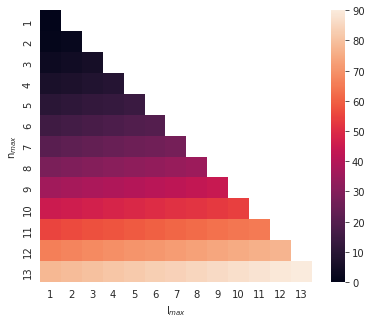

In [8]:

mask = np.zeros_like(MSEs)

mask[np.triu_indices_from(mask,k=1)] = True

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(7, 5))

    ax = sns.heatmap(MSEs, mask=mask,  vmax=90, square=True,xticklabels=[str(i) for i in range(1,n_max+1)],yticklabels=[str(i) for i in range(1,n_max+1)])
    ax.set_xlabel("l$_{max}$")
    ax.set_ylabel("n$_{max}$")

In [ ]:
xticklabels=[]
yticklabels=[]

In [ ]:
# w and w/o projection

In [55]:
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

boston = load_boston()
X, y = boston.data, boston.target
n_features = X.shape[1]

# gradient boosted trees tend to do well on problems like this
reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

In [71]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args


# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters



@dec_check(space)
def objective(this=None,**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

TypeError: dec_check() missing 1 required positional argument: 'space'

In [150]:
import copy

In [190]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.,
              max_radial=3,
              max_angular=3,
              gaussian_sigma_constant=0.3,
              gaussian_sigma_type="Constant",
              radial_basis="GTO",
              normalize=True,
              cutoff_smooth_width=0.3,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False,
              )

space = [Real(10**-5, 10**0, "log-uniform", name='alpha'),
        Integer(1, 5, name='max_radial')]
reg = Ridge()
y = train_properties
atom_groups = atom_groups_by_frame(train_structures)
Feature_gen = BufferedFeatures(train_structures, hypers)


@use_named_args(space)
def soap_objective(**params):
    update_dict = {}
    
    new_params = params.copy()
    
    for key, value in new_params.items():
        if key in Feature_gen.hypers:
            hypers[key] = value
            update_dict[key] = params.pop(key, None)
    
    print(update_dict)
    reg.set_params(**params)
    

    X = Feature_gen.get_features(update_dict)
    print(X.shape)
    
    print(Feature_gen.hypers["max_angular"])
    splits = list(GroupKFold(n_splits=5).split(X,y,groups=atom_groups))
    
    return -np.mean(cross_val_score(reg, X, y, cv=splits, n_jobs=-1,
                                    scoring="neg_mean_squared_error"))

res_gp = gp_minimize(soap_objective, space, n_calls=50, random_state=0)

{'max_radial': 4}
{'max_radial': 4}
{'max_radial': 4}
I initially calculate
(7631, 540)
3
{'max_radial': 4}
{'max_radial': 4}
{'max_radial': 4}
I only return what I store
(7631, 540)
3
{'max_radial': 3}
{'max_radial': 3}
{'max_radial': 3}
I recalculate
3
(7631, 540)
3
{'max_radial': 1}
{'max_radial': 1}
{'max_radial': 1}
I recalculate
3
(7631, 540)
3
{'max_radial': 3}
{'max_radial': 3}
{'max_radial': 3}
I recalculate
3
(7631, 540)
3
{'max_radial': 3}
{'max_radial': 3}
{'max_radial': 3}
I only return what I store
(7631, 540)
3
{'max_radial': 4}
{'max_radial': 4}
{'max_radial': 4}
I recalculate
3
(7631, 540)
3
{'max_radial': 4}
{'max_radial': 4}
{'max_radial': 4}
I only return what I store
(7631, 540)
3


KeyboardInterrupt: 

In [126]:
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

TypeError: __init__() missing 1 required positional argument: 'space'

In [91]:
from functools import wraps

def wrapper(method,space):
    @use_named_args(method,space)
    def _impl(self, *method_args, **method_kwargs):
        method_output = method(self, *method_args, **method_kwargs)
        return method_output 
    return _impl


In [72]:
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Best score=%.4f" % res_gp.fun

'Best score=2.9882'

In [155]:
from copy import deepcopy

In [191]:
class BufferedFeatures:
    def __init__(self, structures, calculator_params, calculator=SOAP):
        
        self.calculator = calculator(**calculator_params)
        self.hypers = deepcopy(self.calculator.hypers)
        self.X = None
        self.structures = structures

    def get_features(self, update_params):
        print(self.calculator.hypers["max_radial"])
        self.calculator.update_hyperparameters(**update_params)
        print(self.calculator.hypers["max_radial"])
        
        if self.X is None:
            print("I initially calculate")
            self.hypers = deepcopy(self.calculator.hypers)
            self.X = self.calculator.transform(self.structures).get_features(self.calculator)
            return self.X
        
        else:
            
            if self.hypers == self.calculator.hypers:
                print("I only return what I store")
                self.hypers = deepcopy(self.calculator.hypers)
                return self.X
            
            else:
                print("I recalculate")
                self.hypers = deepcopy(self.calculator.hypers)
                
                #print(self.calculator.transform(self.structures).get_features(self.calculator).shape)
                return self.X
        #fitted? - yes
        
        #fitted? - no
        

In [181]:
buffered_feat = BufferedFeatures(train_structures,hypers)

TypeError: Object of type int64 is not JSON serializable

In [180]:
this = SOAP(**hypers)

TypeError: Object of type int64 is not JSON serializable

In [132]:
this.hypers

{'max_radial': 3,
 'max_angular': 3,
 'soap_type': 'PowerSpectrum',
 'normalize': True,
 'inversion_symmetry': True,
 'expansion_by_species_method': 'environment wise',
 'global_species': [],
 'compute_gradients': False,
 'cutoff_function': {'type': 'ShiftedCosine',
  'cutoff': {'value': 3.0, 'unit': 'AA'},
  'smooth_width': {'value': 0.3, 'unit': 'AA'}},
 'gaussian_density': {'type': 'Constant',
  'gaussian_sigma': {'value': 0.3, 'unit': 'AA'}},
 'radial_contribution': {'type': 'GTO',
  'optimization': {'Spline': {'accuracy': 1e-05}}}}

In [188]:
this.update_hyperparameters(**hypers)

In [175]:
feat = buffered_feat.get_features(**hypers)

In [176]:
feat.shape

(7631, 540)

In [92]:
class objective:
    
    def objective(reg,**params):
        reg.set_params(**params)
        return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                        scoring="neg_mean_absolute_error"))
    
    
    def __init__(self, reg, space):
        self.reg = reg
        self.space = space
    
    @wrapper(self.space)
    def __call__(self,**params):
        reg.set_params(**params)

        return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                        scoring="neg_mean_absolute_error"))

NameError: name 'self' is not defined

In [ ]:
class objective:

In [67]:
class BufferedCalculator:
    def __init__(self, parameters, calculator=SOAP, **params):

        for key, value in params.items():
            pass
    
    def get
    

In [69]:
SOAP()

TypeError: __init__() missing 5 required positional arguments: 'interaction_cutoff', 'cutoff_smooth_width', 'max_radial', 'max_angular', and 'gaussian_sigma_type'

In [68]:
objective(1,1,jumps=3)

jumps


In [60]:
ob = objective(reg,space)

In [61]:
res_gp = gp_minimize(ob, space, n_calls=50, random_state=0)

TypeError: wrapper() takes 1 positional argument but 2 were given